# Описание проекта

Проект представляет из себя набор функций для получения информации с Московской биржи посредством API стоимости опционов put и call

In [ ]:
import pandas as pd
import numpy as np
import requests as req
import datetime as dt
import time
from scipy.stats import norm, binom

In [2]:
# Определение констант 
SECID = 'ROSN'
END_DATE = dt.datetime.today().strftime('%Y-%m-%d') # Окно заканчивается сегодняшней ценой закрытия
START_DATE = (dt.datetime.today() - dt.timedelta(days=365)).strftime('%Y-%m-%d') # Начало окна календарный год назад
WINDOW = 252 # Окно торговых дней

# Функции проекта

## Получение исторических данных об акции

In [5]:
# Функция для извлечения данных с JSON объекта
def flatten(j: dict, blockname: str):
    columns = j[blockname]['columns']
    return [{k: r[I] for I, k in enumerate(columns)} for r in j[blockname]['data']]

# Функция для запроса тикера и извлечения данных с JSON объекта
def get_moex_stock_data(secid, start_date, end_date, engine='stock', market='shares', board='TQBR'):
    # Преобразование дат в объекты datetime, если они являются строками
    if isinstance(start_date, str):
        start_date = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
    if isinstance(end_date, str):
        end_date = dt.datetime.strptime(end_date, "%Y-%m-%d").date()

    all_data = []
    current_start_date = start_date

    while current_start_date <= end_date:
        current_end_date = current_start_date + dt.timedelta(days=99)
        if current_end_date > end_date:
            current_end_date = end_date

        # Запрос к MOEX
        url = f"https://iss.moex.com/iss/history/engines/{engine}/markets/{market}/boards/{board}/securities/{secid}.json?from={current_start_date}&till={current_end_date}&iss.meta=off"
        try:
            r = req.get(url)
            r.encoding = 'utf-8'
            j = r.json()

            # Преобразование ответа и добавление данных в список all_data
            flattened_data = flatten(j, 'history')
            all_data.extend(flattened_data)

            # Переход к следующему периоду
            current_start_date = current_end_date + dt.timedelta(days=1)

            # Добавление задержки, чтобы избежать отправки слишком большого количества запросов за короткий период
            time.sleep(1)

        except req.exceptions.RequestException as e:
            print(f"Запрос не удался: {e}")
            break

    return all_data

# Функция для обработки данных и упрощения данных
def get_moex_data_and_prepare(secid, start_date, end_date):
    data = get_moex_stock_data(secid, start_date, end_date)
    df = pd.DataFrame(data)
    df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
    df.set_index('TRADEDATE', inplace=True)
    df = df[['CLOSE']].asfreq("B").fillna(method='ffill')
    df.columns = [f'{secid}_Stock_Price']
    df[f'{secid}_Daily_Return'] = df[f'{secid}_Stock_Price'].pct_change()
    df['Volatility'] = df[f'{secid}_Daily_Return'].rolling(window=WINDOW).std() * (WINDOW ** 0.5)
    df.dropna(inplace=True)
    
    return df

### Описание функций 

__- flatten__ используется для преобразования вложенного JSON-объекта, полученного из MOEX API, в плоский список словарей. 

Применяется в других методах получения данных

Параметры:

- j (dict): JSON-объект, полученный из MOEX API. Этот объект должен содержать блок данных с определёнными столбцами и значениями.
- blockname (str): Имя ключа в JSON-объекте, который содержит необходимые данные. Обычно этот ключ указывает на блок данных, например, “history”.

__- Функция get_moex_stock_data__ Функция возвращает список словарей, где каждый словарь представляет одну запись с данными о ценах акций.

Параметры:

- secid (str): Идентификатор ценной бумаги.
- start_date (str or datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
- end_date (str or datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.
- engine (str): Движок рынка. По умолчанию ‘stock’.
- market (str): Рынок. По умолчанию ‘shares’.
- board (str): Торговая площадка. По умолчанию ‘TQBR’.

__- get_moex_data_and_prepare__ - извлекает данные о ценах акций с MOEX API за заданный период времени.

Параметры:

- secid (str): Идентификатор ценной бумаги.
- start_date (str or datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
- end_date (str or datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.


## Получение информации о текущей стоимости акции

In [7]:
# Функция для получения текущей информации об акции
def get_current_stock_info(secid):
    url = f'https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/{secid}.json'
    r = req.get(url)
    j = r.json()
    market_data = flatten(j, 'marketdata')
    
    return market_data[0]

def get_current_stock_price(secid):
    stock_info = get_current_stock_info(secid)
    stock_price = stock_info['LAST']
    return stock_price

### Описание функций 

__- get_current_stock_info__  
Функция возвращает текущую информацию об акции с Московской биржи (MOEX), преобразуя данные API в плоский словарь.

**Параметры:**  
- `secid` (str): Идентификатор ценной бумаги.

**Возвращаемое значение:**  
- Словарь, содержащий текущие данные об акции, включая цену, объем, изменение и другие метрики.

**Примечание:**  
Функция использует метод `flatten` для преобразования вложенного JSON-объекта в плоский список словарей.

---

__- get_current_stock_price__  
Функция возвращает текущую цену акции на основе данных, полученных с Московской биржи (MOEX).

**Параметры:**  
- `secid` (str): Идентификатор ценной бумаги.

**Возвращаемое значение:**  
- `float`: Текущая цена акции из поля `LAST`.

## Получение информации о безрисковой ставке

In [9]:
def get_rf_moex(date, engine='stock'):
    url = f"https://iss.moex.com/iss/engines/{engine}/zcyc.json?date={date}&iss.meta=off"
    r = req.get(url)
    r.encoding = 'utf-8-sig'
    return r.json()

def get_risk_free_rate(date, period=1.0):
    response_json = get_rf_moex(date)    
    yearyields_data = response_json.get('yearyields', {})
    columns = yearyields_data.get('columns', [])
    data = yearyields_data.get('data', [])
    
    for row in data:
        yield_info = {columns[i]: row[i] for i in range(len(columns))}
        if yield_info.get('period') == period:
            return round(yield_info.get('value') / 100,3)
    
    return None

__- get_rf_moex__  
Функция запрашивает данные о безрисковой доходности (zero-coupon yield curve) с Московской биржи (MOEX) за указанный день.

**Параметры:**  
- `date` (str): Дата запроса в формате "YYYY-MM-DD".  
- `engine` (str): Движок рынка. По умолчанию `'stock'`.  

**Возвращаемое значение:**  

- JSON-объект, содержащий данные о безрисковой доходности.  
 
---

__- get_risk_free_rate__  
Функция возвращает безрисковую ставку доходности (risk-free rate) для указанного периода на заданную дату.  

**Параметры:**  
- `date` (str): Дата запроса в формате "YYYY-MM-DD".  
- `period` (float): Период доходности (в годах). По умолчанию `1.0` (один год).  

**Возвращаемое значение:**  
- `float`: Безрисковая ставка доходности (в долях, например, `0.05` для 5%).  
- `None`: Если ставка для указанного периода отсутствует.  

## Расчет стоимости опциона по модели Модель Блэка — Шоулза и информация о греках

In [72]:
def fraction_of_year(days=14):
    year = dt.datetime.now().year

    # Определяем високосный или обычный год
    days_in_year = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365

    fraction = days / days_in_year
    return fraction

def black_scholes(S, K, t, r, sigma, option_type='call'):
    #Рассчитываем долю года используя функцию fraction_of_year
    T = fraction_of_year(t)
  
    # Расчет d1 и d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Расчет ценыв зависимости от типа опциона
    if option_type.lower() == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    #Греки:
    delta = None
    if option_type.lower() == 'call':
        delta = norm.cdf(d1)
    elif option_type.lower() == 'put':
        delta = norm.cdf(d1) - 1

    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))

    if option_type.lower() == 'call':
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 - r * K * np.exp(-r * T) * norm.cdf(d2))
    elif option_type.lower() == 'put':
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * norm.cdf(-d2))
    
    vega = S * norm.pdf(d1) * np.sqrt(T)

    if option_type.lower() == 'call':
        rho = K * T * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)

    option = {
        'цена' : option_price,
        'delta': delta,
        'gamma': gamma,
        'theta': theta,
        'vega': vega,
        'rho': rho
    }

    option_df = pd.DataFrame([option]).round(5)


    return option_df

### Описание функций

__- fraction_of_year__  
Функция вычисляет долю года, соответствующую указанному количеству дней.  

**Параметры:**  
- `days` (int): Количество дней. По умолчанию `14`.  

**Возвращаемое значение:**  
- `float`: Доля года, соответствующая указанному количеству дней.  

**Примечание:**  
Функция учитывает високосный год, определяя количество дней в текущем году (365 или 366).  

---

__- black_scholes__  
Функция вычисляет цену опциона и его греки (дельта, гамма, тета, вега, ро) с использованием модели Блэка-Шоулза.  

**Параметры:**  
- `S` (float): Текущая цена базового актива.  
- `K` (float): Страйк-цена опциона.  
- `t` (int): Время до истечения опциона в днях.  
- `r` (float): Безрисковая процентная ставка (в долях, например, `0.05` для 5%).  
- `sigma` (float): Волатильность базового актива (в долях, например, `0.2` для 20%).  
- `option_type` (str): Тип опциона – `'call'` для колл-опциона, `'put'` для пут-опциона. По умолчанию `'call'`.  

**Возвращаемое значение:**  
- `pd.DataFrame`: Таблица, содержащая рассчитанную цену опциона и его греки:  
  - `цена`: Стоимость опциона.  
  - `delta`: Дельта опциона.  
  - `gamma`: Гамма опциона.  
  - `theta`: Тета опциона.  
  - `vega`: Вега опциона.  
  - `rho`: Ро опциона.  


# Пример использования

In [74]:
risk_free_rate = get_risk_free_rate('2024-11-28')
ticker_df = get_moex_data_and_prepare(SECID, START_DATE, END_DATE)
volatility = ticker_df['Volatility'].tail(1).item()
price = get_current_stock_price(SECID)

/var/folders/pk/4b6mpfcx3p7bn9sg_s3hkv6r0000gn/T/ipykernel_4910/2177521077.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df[['CLOSE']].asfreq("B").fillna(method='ffill')


In [75]:
ticker_df

,ROSN_Stock_Price,ROSN_Daily_Return,Volatility
TRADEDATE,,,
2024-11-19,459.70,-0.025956,0.236478
2024-11-20,449.25,-0.022732,0.236897
2024-11-21,458.95,0.021592,0.237321
2024-11-22,459.90,0.002070,0.236888
2024-11-25,453.65,-0.013590,0.237102
2024-11-26,450.80,-0.006282,0.237029
2024-11-27,474.15,0.051797,0.242217
2024-11-28,474.85,0.001476,0.242045
2024-11-29,478.00,0.006634,0.241854


In [76]:
put = black_scholes(price, 550, 4, risk_free_rate, volatility, 'put')
call = black_scholes(price, 425, 4, risk_free_rate, volatility, 'call')

In [77]:
print('Оцион-put на Роснефть, при цене страйка 550\n')
display(put)
print('\nОцион-call на Роснефть, при цене страйка 425\n')
display(call)

Оцион-put на Роснефть, при цене страйка 550



,цена,delta,gamma,theta,vega,rho
0,70.66119,-1.0,0.0,122.35136,0.00001,-5.9963



Оцион-call на Роснефть, при цене страйка 425



,цена,delta,gamma,theta,vega,rho
0,54.03453,1.0,0.0,-94.54688,0.00024,4.6335


Теоретическая цена на основе исторических данных +- получается на уровне калькуляции Московской биржи

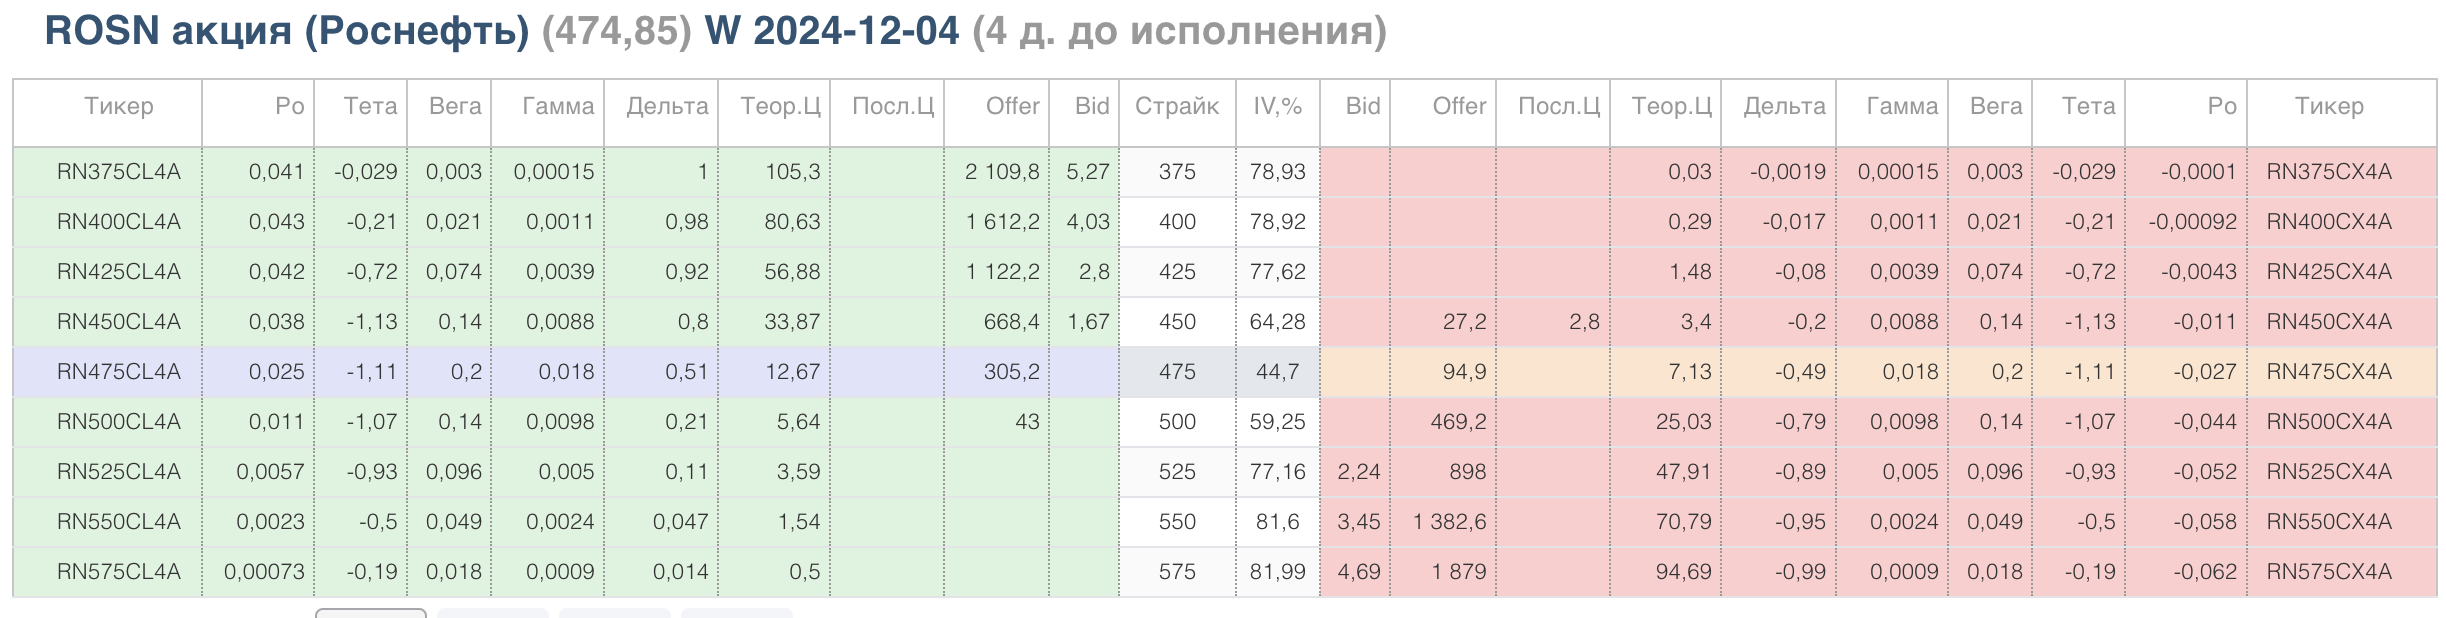